Рассмотрим задачу кластеризации и попробуем применить метод k-средних. 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

Создадим набор данных, состоящих из 150 случайно сгенерированных точек, которые грубо сгруппированы в три области с более высокой плотностью. 

In [4]:
X, y = make_blobs(n_samples=150, n_features=2,centers=3,cluster_std=0.5, shuffle=True, random_state=0)

Построим график рассеяния

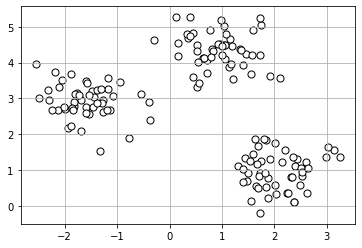

In [10]:
plt.scatter(X[:,0],X[:,1],c='white', marker='o', edgecolor='black',s=50)
plt.grid()
plt.show()

In [12]:
km = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
# n_clusters - число кластеров
# n_init - сколько раз необходимо выполнить кластеризацию с разными центроидами
# max_iter - максимальное число итераций для каждого запуска
# tol - параметр, который управляет порогом изменения во внутрекластерной сумме квадратичных ошибок для заявления о сходимости
y_km = km.fit_predict(X)

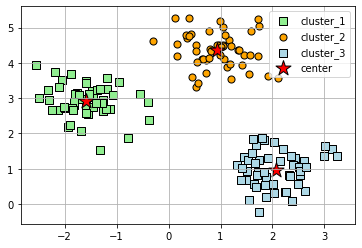

In [13]:
# построим новый график рассеяния после применения метода
plt.scatter(X[y_km == 0, 0],X[y_km == 0, 1], s=50, c='lightgreen', marker='s', edgecolor='black', label='cluster_1')
plt.scatter(X[y_km == 1, 0],X[y_km == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster_2')
plt.scatter(X[y_km == 2, 0],X[y_km == 2, 1], s=50, c='lightblue', marker='s', edgecolor='black', label='cluster_3')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=250, marker='*', c='red', edgecolor='black',label='center')
# в clusters_centers_ - хранятся центроиды
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Рассмотрим более популярный вариант классического метода k-средних под названием k++, который способен значительно улучшить результаты кластеризации путем более искусного выбора начальных центров кластеров. 
Инициализацию методов k-means++ можно свести к следующим шагам. 
1. Инициализировать пустой набор M для хранения выбираемых k центроидов

2. Случайным образом выбрать из входных образцов первый центроид и присвоить его M

3. Для каждого образца отсутствующего в M,найти минимальное квадратичное расстояние ко всем центроидам в M

4. Для случайного выбора следующего центроида использовать распределение взвешенных вероятностей

### Использование метода "локтя" для нахождения оптимального количества кластеров

Одно из основных затруднений в обучении без учителя связано с тем, что окончательный ответ нам не известен.  Следовательно, для количественной оценки качества кластеризации нам необходимо использовать внутренние метрики, например внутрикластерное значение - искажение. 

Для оценки оптимального количества кластеров k используем метод "локтя". С увеличением k искажение будет понижаться, причина в том, что образцы станут располагаться ближе к центроидам, которым они назначены. 

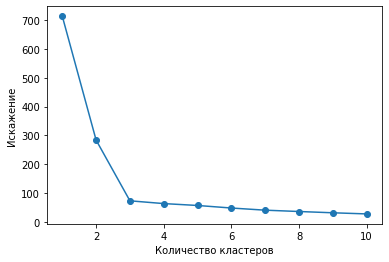

In [15]:
distortions = []
for i in range(1,11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel("Количество кластеров")
plt.ylabel("Искажение")
plt.show()

На графике видно, что "локоть" находится в точке k = 3, следовательно для наших данных это лучший выбор. 
### Количественная оценка качества кластеризации через графики силуэтов
Еще одной внутренней метрикой для оценки качества кластеризации является **анализ силуэтов**, чтобы вычислить **коэффициент силуэта** одиночного образца в наборе данных, мы должны выполнить три шага:
    1. Вычислить **связность кластера a** как среднее расстояние между образцом x и всеми остальными точками в том же самом кластере
    2. Вычислить **отделение кластера b** от следующего ближайшего кластера как среднее расстояние между образцом x и всеми образцами в ближайшем кластере. 
    3. Вычислить силуэт, как разность между связностью и отделением кластера, деления на большее из них значение 
    
Рассмотрим пример с числом кластеров - 3. 

In [28]:
km = KMeans(n_clusters=3, n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

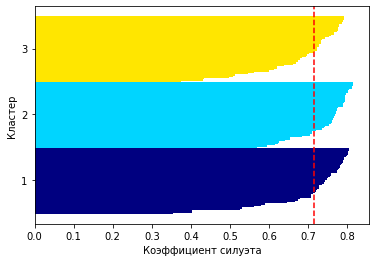

In [29]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X,y_km,metric='euclidean') # вычисление коэффициента силуэта
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Кластер')
plt.xlabel('Коэффициент силуэта')
plt.show()

In [30]:
# Рассмотрим пример, с числом кластеров - 2
km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

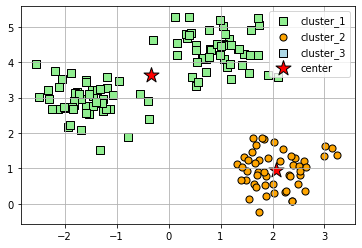

In [31]:
plt.scatter(X[y_km == 0, 0],X[y_km == 0, 1], s=50, c='lightgreen', marker='s', edgecolor='black', label='cluster_1')
plt.scatter(X[y_km == 1, 0],X[y_km == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster_2')
plt.scatter(X[y_km == 2, 0],X[y_km == 2, 1], s=50, c='lightblue', marker='s', edgecolor='black', label='cluster_3')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=250, marker='*', c='red', edgecolor='black',label='center')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [32]:
km = KMeans(n_clusters=2, n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

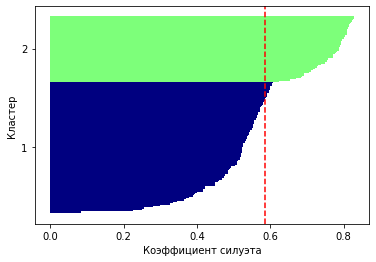

In [33]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X,y_km,metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Кластер')
plt.xlabel('Коэффициент силуэта')
plt.show()

На графике видно, что относительно графика для (n_clusters = 3) силуэты заметно отличаются по длине и ширине, что подтверждает плохую кластеризацию. 